Import modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

try:
    from inplace_abn import InPlaceABN
except ImportError:
    !pip install inplace-abn
    from inplace_abn import InPlaceABN

class Conv2dReLU(nn.Sequential):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            stride=1,
            use_batchnorm=True,
    ):

        if use_batchnorm == "inplace" and InPlaceABN is None:
            raise RuntimeError(
                "In order to use `use_batchnorm='inplace'` inplace_abn package must be installed. "
                + "To install see: https://github.com/mapillary/inplace_abn"
            )

        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        if use_batchnorm == "inplace":
            bn = InPlaceABN(out_channels, activation="leaky_relu", activation_param=0.0)
            relu = nn.Identity()

        elif use_batchnorm and use_batchnorm != "inplace":
            bn = nn.BatchNorm2d(out_channels)

        else:
            bn = nn.Identity()

        super(Conv2dReLU, self).__init__(conv, bn, relu)

class Conv3dReLU(nn.Sequential):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            stride=1,
            use_batchnorm=True,
    ):

        if use_batchnorm == "inplace" and InPlaceABN is None:
            raise RuntimeError(
                "In order to use `use_batchnorm='inplace'` inplace_abn package must be installed. "
                + "To install see: https://github.com/mapillary/inplace_abn"
            )

        conv = nn.Conv3d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        if use_batchnorm == "inplace":
            bn = InPlaceABN(out_channels, activation="leaky_relu", activation_param=0.0)
            relu = nn.Identity()

        elif use_batchnorm and use_batchnorm != "inplace":
            bn = nn.BatchNorm3d(out_channels)

        else:
            bn = nn.Identity()

        super(Conv3dReLU, self).__init__(conv, bn, relu)
class PAB2D(nn.Module):
    def __init__(self, in_channels, out_channels, pab_channels=64):
        super(PAB2D, self).__init__()
        # Series of 1x1 conv to generate attention feature maps
        self.pab_channels = pab_channels
        self.in_channels = in_channels
        self.top_conv = nn.Conv2d(in_channels, pab_channels, kernel_size=1)
        self.center_conv = nn.Conv2d(in_channels, pab_channels, kernel_size=1)
        self.bottom_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.map_softmax = nn.Softmax(dim=1)
        self.out_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        bsize = x.size()[0]
        h = x.size()[2]
        w = x.size()[3]
        x_top = self.top_conv(x)
        x_center = self.center_conv(x)
        x_bottom = self.bottom_conv(x)

        x_top = x_top.flatten(2)
        x_center = x_center.flatten(2).transpose(1, 2)
        x_bottom = x_bottom.flatten(2).transpose(1, 2)

        sp_map = torch.matmul(x_center, x_top)
        sp_map = self.map_softmax(sp_map.view(bsize, -1)).view(bsize, h*w, h*w)
        sp_map = torch.matmul(sp_map, x_bottom)
        sp_map = sp_map.reshape(bsize, self.in_channels, h, w)
        x = x + sp_map
        x = self.out_conv(x)
        # print('x_top',x_top.shape,'x_center',x_center.shape,'x_bottom',x_bottom.shape,'x',x.shape,'sp_map',sp_map.shape)
        return x

class MFAB2D(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, use_batchnorm=True, reduction=16):
        # MFAB is just a modified version of SE-blocks, one for skip, one for input
        super(MFAB2D, self).__init__()
        self.hl_conv = nn.Sequential(
            Conv2dReLU(
                in_channels,
                in_channels,
                kernel_size=3,
                padding=1,
                use_batchnorm=use_batchnorm,
            ),
            Conv2dReLU(
                in_channels,
                skip_channels,
                kernel_size=1,
                use_batchnorm=use_batchnorm,
            )
        )
        self.SE_ll = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(skip_channels, skip_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(skip_channels // reduction, skip_channels, 1),
            nn.Sigmoid(),
        )
        self.SE_hl = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(skip_channels, skip_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(skip_channels // reduction, skip_channels, 1),
            nn.Sigmoid(),
        )
        self.conv1 = Conv2dReLU(
            skip_channels + skip_channels,  # we transform C-prime form high level to C from skip connection
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )

    def forward(self, x, skip=None):
        x = self.hl_conv(x)
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        attention_hl = self.SE_hl(x)
        if skip is not None:
            attention_ll = self.SE_ll(skip)
            attention_hl = attention_hl + attention_ll
            x = x * attention_hl
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class PAB3D(nn.Module):
    def __init__(self, in_channels, out_channels, pab_channels=64):
        super(PAB3D, self).__init__()
        # Series of 1x1 conv to generate attention feature maps
        self.pab_channels = pab_channels
        self.in_channels = in_channels
        self.top_conv = nn.Conv3d(in_channels, pab_channels, kernel_size=1)
        self.center_conv = nn.Conv3d(in_channels, pab_channels, kernel_size=1)
        self.bottom_conv = nn.Conv3d(in_channels, in_channels, kernel_size=3, padding=1)
        self.map_softmax = nn.Softmax(dim=1)
        self.out_conv = nn.Conv3d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        bsize = x.size()[0]
        h = x.size()[2]
        w = x.size()[3]
        d = x.size()[4]
        x_top = self.top_conv(x)
        x_center = self.center_conv(x)
        x_bottom = self.bottom_conv(x)

        x_top = x_top.flatten(2)
        x_center = x_center.flatten(2).transpose(1, 2)
        x_bottom = x_bottom.flatten(2).transpose(1, 2)
        sp_map = torch.matmul(x_center, x_top)
        sp_map = self.map_softmax(sp_map.view(bsize, -1)).view(bsize, h*w*d, h*w*d)
        sp_map = torch.matmul(sp_map, x_bottom)
        sp_map = sp_map.reshape(bsize, self.in_channels, h, w, d)
        x = x + sp_map
        x = self.out_conv(x)
        # print('x_top',x_top.shape,'x_center',x_center.shape,'x_bottom',x_bottom.shape,'x',x.shape,'sp_map',sp_map.shape)
        return x

class MFAB3D(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, use_batchnorm=True, reduction=16):
        # MFAB is just a modified version of SE-blocks, one for skip, one for input
        super(MFAB3D, self).__init__()
        self.hl_conv = nn.Sequential(
            Conv3dReLU(
                in_channels,
                in_channels,
                kernel_size=3,
                padding=1,
                use_batchnorm=use_batchnorm,
            ),
            Conv3dReLU(
                in_channels,
                skip_channels,
                kernel_size=1,
                use_batchnorm=use_batchnorm,
            )
        )
        self.SE_ll = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(skip_channels, skip_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv3d(skip_channels // reduction, skip_channels, 1),
            nn.Sigmoid(),
        )
        self.SE_hl = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(skip_channels, skip_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv3d(skip_channels // reduction, skip_channels, 1),
            nn.Sigmoid(),
        )
        self.conv1 = Conv3dReLU(
            skip_channels + skip_channels,  # we transform C-prime form high level to C from skip connection
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.conv2 = Conv3dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )

    def forward(self, x, skip=None):
        x = self.hl_conv(x)
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        attention_hl = self.SE_hl(x)
        if skip is not None:
            attention_ll = self.SE_ll(skip)
            attention_hl = attention_hl + attention_ll
            x = x * attention_hl
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

Define 2D MANET

In [2]:
class DoubleConv2D(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down2D(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv2D(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up2D(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv2D(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv2D(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv2D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv2D, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet2D(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, c=64, use_batchnorm=True):
        super(UNet2D, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv2D(n_channels, c)
        self.down1 = Down2D(c, 2*c)
        self.down2 = Down2D(2*c, 4*c)
        self.down3 = Down2D(4*c, 8*c)
        factor = 2 if bilinear else 1
        self.down4 = Down2D(8*c, 16*c // factor)
        self.pab = PAB2D(8*c,8*c)
        self.up1 = Up2D(16*c, 8*c // factor, bilinear)
        self.up2 = Up2D(8*c, 4*c // factor, bilinear)
        self.up3 = Up2D(4*c, 2*c // factor, bilinear)
        self.up4 = Up2D(2*c, c, bilinear)

        self.mfab1 = MFAB2D(8*c,8*c,4*c,use_batchnorm)
        self.mfab2 = MFAB2D(4*c,4*c,2*c,use_batchnorm)
        self.mfab3 = MFAB2D(2*c,2*c,c,use_batchnorm)
        self.mfab4 = MFAB2D(c,c,c,use_batchnorm)
        self.outc = OutConv2D(c, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x5 = self.pab(x5)
        
        x = self.mfab1(x5,x4)
        x = self.mfab2(x,x3)
        x = self.mfab3(x,x2)
        x = self.mfab4(x,x1)

        # x = self.up1(x5, x4)
        # x = self.up2(x, x3)
        # x = self.up3(x, x2)
        # x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Toy dataloader

In [3]:
import torch.optim as optim
import matplotlib.pyplot as plt

def get_inputs2D(batch=4,size=384,noise_ratio=5,p_threshold=0.3):
  x = torch.rand(batch,1,size,size) * noise_ratio
  y = torch.zeros(batch,1,size,size)
  for idx in range(len(y)):
    p = torch.rand(1) 
    while p >p_threshold:
      x1 = torch.randint(0,int(size/2),[1])[0]
      x2 = torch.randint(int(size/2),size,[1])[0]
      y[idx,:,x1:x2,x1:x2] = 1
      p = torch.rand(1) 
  x = x + y
  x = x/x.max()
  return x,y

def get_inputs3D(batch=2,h=256,w=256,d=32,noise_ratio=5,p_threshold=0.3):
  
  x = torch.rand(batch,1,h,w,d) * noise_ratio
  y = torch.zeros(batch,1,h,w,d)
  for idx in range(len(y)):      
    p = torch.rand(1) 
    while p >p_threshold:
      h1 = torch.randint(0,int(h/2),[1])[0]
      h2 = torch.randint(int(h/2),h,[1])[0]
      w1 = torch.randint(0,int(w/2),[1])[0]
      w2 = torch.randint(int(w/2),w,[1])[0]
      d1 = torch.randint(0,int(d/2),[1])[0]
      d2 = torch.randint(int(d/2),d,[1])[0]
      y[idx,:,h1:h2,w1:w2,d1:d2] = 1
      p = torch.rand(1)
  x = x + y
  x = x/x.max()
  return x,y

Toy 2D segmentation using batchnorm

In [4]:
import time
net = UNet2D(1,2,c=64,use_batchnorm=True)
net = net.cuda()
epochs = 50
lossfn = nn.CrossEntropyLoss()
activefn = nn.Softmax(1)
optimizer = optim.Adam(net.parameters(),lr=1e-3)

# train
start = time.time()
for epoch in range(epochs):
    optimizer.zero_grad()
    x,y = get_inputs2D()
    x,y = x.cuda(),y.cuda()
    yhat = net(x)
    yhat = activefn(yhat)
    loss = lossfn(yhat,y[:,0].long())
    loss.backward()
    optimizer.step()
    print('epoch',epoch,loss)

done = time.time()
elapsed = done - start
print('elapsed time', elapsed)

epoch 0 tensor(0.8999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 1 tensor(0.7036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 2 tensor(0.5178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 3 tensor(0.4425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 4 tensor(0.4994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 5 tensor(0.5429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 6 tensor(0.3950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 7 tensor(0.3760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 8 tensor(0.4977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 9 tensor(0.4241, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 10 tensor(0.5879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 11 tensor(0.3782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 12 tensor(0.4043, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 13 tensor(0.5162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 14 tensor(0.3711, device

Toy 2D segmentation using inplace norm

In [5]:
import time
net = UNet2D(1,2,use_batchnorm='inplace')
net = net.cuda()
epochs = 50
lossfn = nn.CrossEntropyLoss()
activefn = nn.Softmax(1)
optimizer = optim.Adam(net.parameters(),lr=1e-3)

# train
net.train()
start = time.time()
for epoch in range(epochs):
    optimizer.zero_grad()
    x,y = get_inputs2D()
    x,y = x.cuda(),y.cuda()
    yhat = net(x)
    yhat = activefn(yhat)
    loss = lossfn(yhat,y[:,0].long())
    loss.backward()
    optimizer.step()
    print('epoch',epoch,loss)

done = time.time()
elapsed = done - start
print('elapsed time', elapsed)

epoch 0 tensor(0.6752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 1 tensor(0.4953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 2 tensor(0.4217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 3 tensor(0.4346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 4 tensor(0.4335, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 5 tensor(0.3591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 6 tensor(0.3705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 7 tensor(0.3826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 8 tensor(0.3719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 9 tensor(0.3624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 10 tensor(0.6112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 11 tensor(0.3597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 12 tensor(0.3459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 13 tensor(0.3441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 14 tensor(0.3450, device

Evaluation 2D segmentation

torch.Size([4, 1, 384, 384]) torch.Size([4, 1, 384, 384]) torch.Size([4, 2, 384, 384]) tensor([5.2787e-08, 5.6887e-08, 5.7352e-08,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], device='cuda:0')


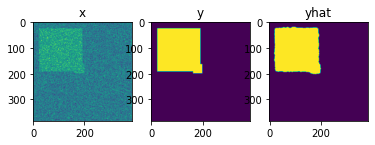

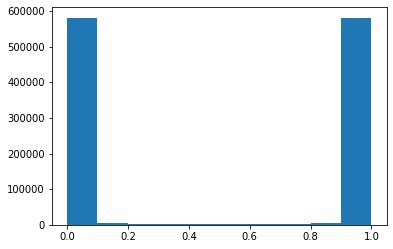

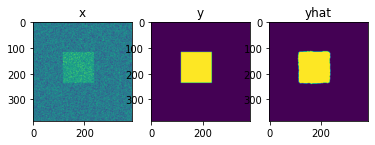

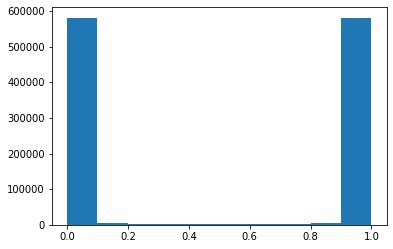

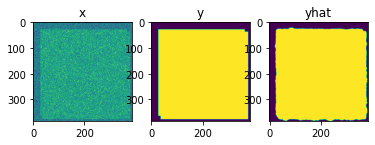

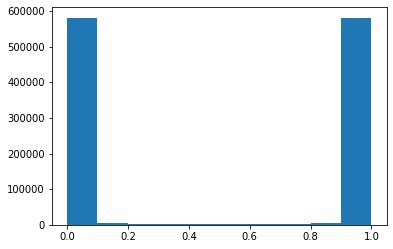

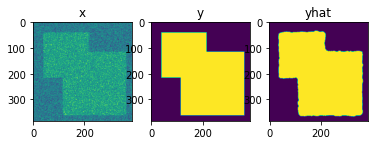

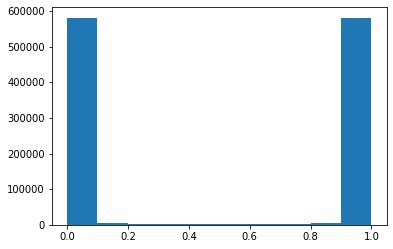

In [6]:
# test
net.eval()
with torch.no_grad():
  x,y = get_inputs2D()
  x,y = x.cuda(),y.cuda()
  yhat = net(x)
  yhat = activefn(yhat)
  print(x.shape,y.shape,yhat.shape,torch.unique(yhat))

  for idx in range(len(y)):
    plt.subplot(131)
    plt.imshow(x[idx,0].cpu().detach().numpy())    
    plt.title('x')
    plt.subplot(132)
    plt.title('y')
    plt.imshow(y[idx,0].cpu().detach().numpy())    
    plt.subplot(133)
    plt.title('yhat')
    plt.imshow(torch.argmax(yhat,1)[idx].cpu().detach().numpy())
    plt.show()
    plt.hist(yhat.cpu().detach().numpy().flatten())
    plt.show()

Define 3D segmentation

In [7]:
class DoubleConv3D(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down3D(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv3D(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up3D(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv3D(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose3d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv3D(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv3D, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, c=64,use_batchnorm=True):
        super(UNet3D, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv3D(n_channels, c)
        self.down1 = Down3D(c, 2*c)
        self.down2 = Down3D(2*c, 4*c)
        self.down3 = Down3D(4*c, 8*c)
        factor = 2 if bilinear else 1
        self.down4 = Down3D(8*c, 16*c // factor)
        self.pab = PAB3D(8*c,8*c)
        self.up1 = Up3D(16*c, 8*c // factor, bilinear)
        self.up2 = Up3D(8*c, 4*c // factor, bilinear)
        self.up3 = Up3D(4*c, 2*c // factor, bilinear)
        self.up4 = Up3D(2*c, c, bilinear)

        self.mfab1 = MFAB3D(8*c,8*c,4*c,use_batchnorm)
        self.mfab2 = MFAB3D(4*c,4*c,2*c,use_batchnorm)
        self.mfab3 = MFAB3D(2*c,2*c,c,use_batchnorm)
        self.mfab4 = MFAB3D(c,c,c,use_batchnorm)
        self.outc = OutConv3D(c, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x5 = self.pab(x5)
        
        x = self.mfab1(x5,x4)
        x = self.mfab2(x,x3)
        x = self.mfab3(x,x2)
        x = self.mfab4(x,x1)

        # x = self.up1(x5, x4)
        # x = self.up2(x, x3)
        # x = self.up3(x, x2)
        # x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Toy 3D segmentation using batchnorm

In [8]:
import time
net = UNet3D(1,2,c=32,use_batchnorm=True)
net = net.cuda()
epochs = 100
lossfn = nn.CrossEntropyLoss()
activefn = nn.Softmax(1)
optimizer = optim.Adam(net.parameters(),lr=1e-3)

# train
net.train()
start = time.time()
for epoch in range(epochs):
    optimizer.zero_grad()
    x,y = get_inputs3D()
    x,y = x.cuda(),y.cuda()
    yhat = net(x)
    yhat = activefn(yhat)
    loss = lossfn(yhat,y[:,0].long())
    loss.backward()
    optimizer.step()
    print('epoch',epoch,loss)

done = time.time()
elapsed = done - start
print('elapsed time', elapsed)

epoch 0 tensor(0.6886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 1 tensor(0.5522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 2 tensor(0.4886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 3 tensor(0.4860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 4 tensor(0.4661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 5 tensor(0.4364, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 6 tensor(0.4249, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 7 tensor(0.6477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 8 tensor(0.4185, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 9 tensor(0.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 10 tensor(0.4271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 11 tensor(0.4181, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 12 tensor(0.5059, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 13 tensor(0.4568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 14 tensor(0.4194, device

Toy 3D segmentation using inplace norm

In [9]:
import time
net = UNet3D(1,2,c=32,use_batchnorm='inplace')
net = net.cuda()
epochs = 100
lossfn = nn.CrossEntropyLoss()
activefn = nn.Softmax(1)
optimizer = optim.Adam(net.parameters(),lr=1e-3)

# train
net.train()
start = time.time()
for epoch in range(epochs):
    optimizer.zero_grad()
    x,y = get_inputs3D()
    x,y = x.cuda(),y.cuda()
    yhat = net(x)
    yhat = activefn(yhat)
    loss = lossfn(yhat,y[:,0].long())
    loss.backward()
    optimizer.step()
    print('epoch',epoch,loss)

done = time.time()
elapsed = done - start
print('elapsed time', elapsed)

epoch 0 tensor(0.7253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 1 tensor(0.7543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 2 tensor(0.5905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 3 tensor(0.7094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 4 tensor(0.5014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 5 tensor(0.4927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 6 tensor(0.5592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 7 tensor(0.6136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 8 tensor(0.4826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 9 tensor(0.5449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 10 tensor(0.5200, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 11 tensor(0.5101, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 12 tensor(0.4533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 13 tensor(0.4616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
epoch 14 tensor(0.4857, device

Evaluation 3D segmentation

torch.Size([2, 1, 256, 256, 32]) torch.Size([2, 1, 256, 256, 32]) torch.Size([2, 2, 256, 256, 32]) tensor([0.0013, 0.0013, 0.0013,  ..., 0.9987, 0.9987, 0.9987], device='cuda:0')

idx_batch 0


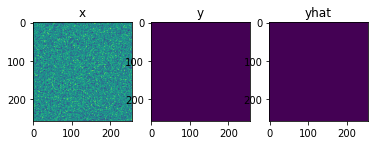

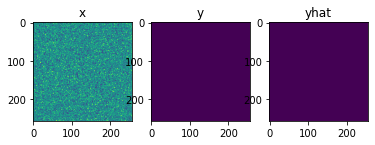

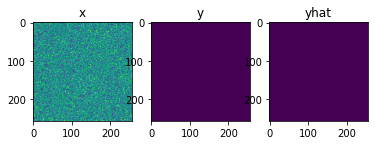

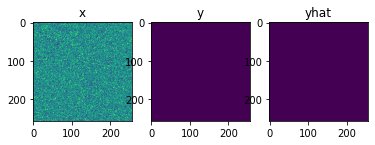

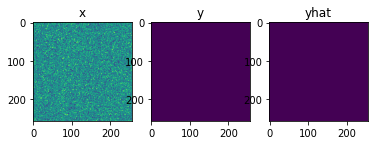

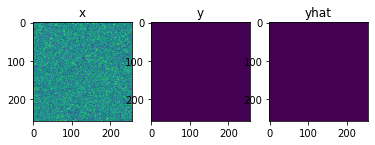

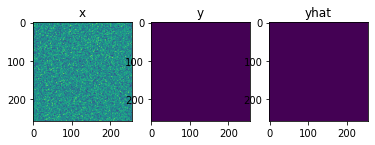

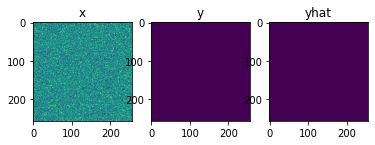

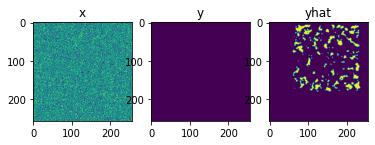

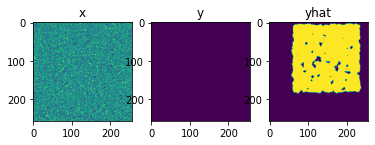

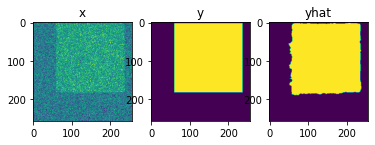

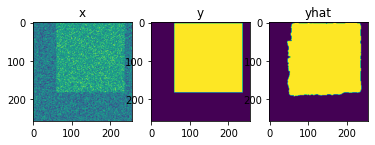

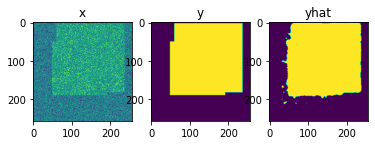

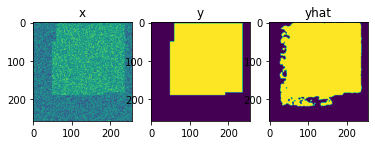

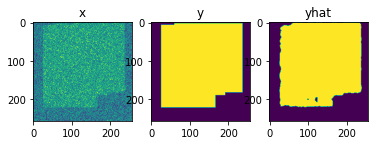

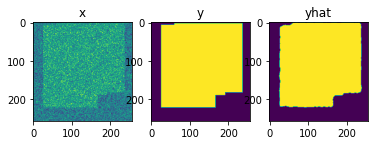

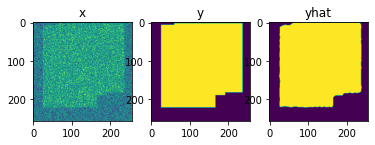

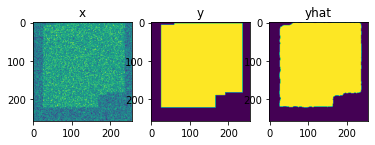

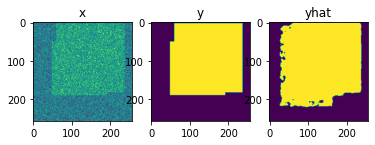

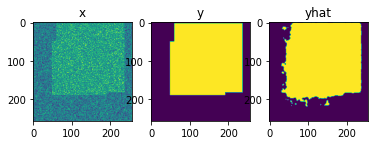

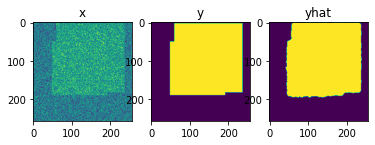

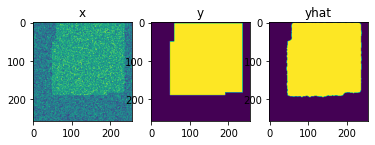

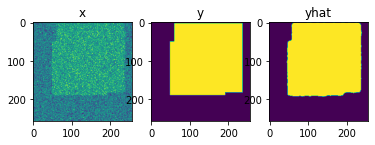

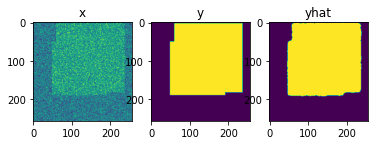

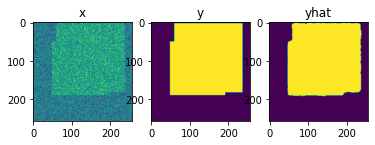

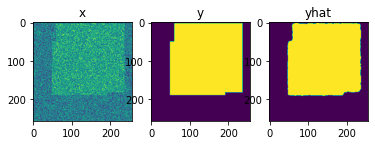

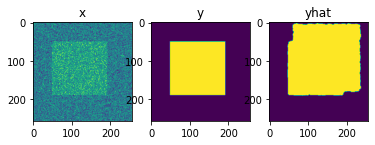

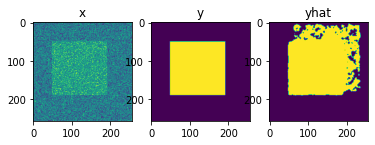

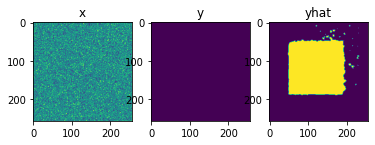

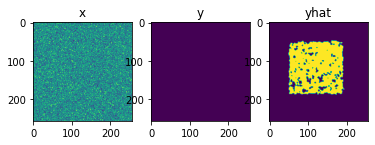

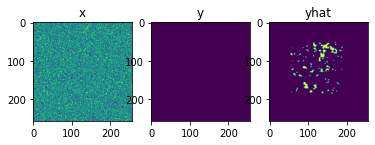

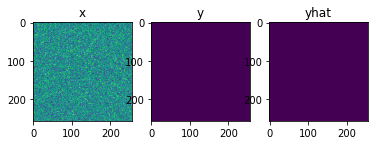


idx_batch 1


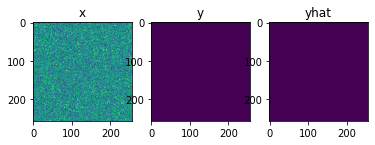

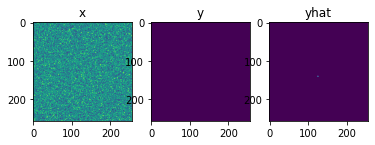

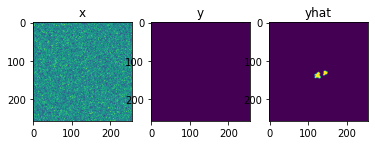

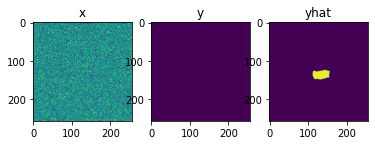

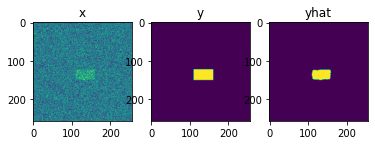

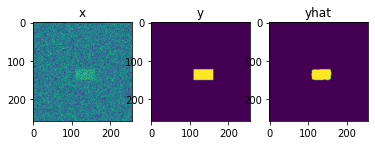

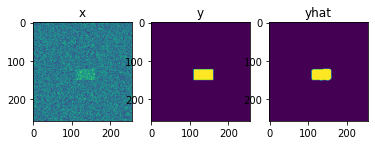

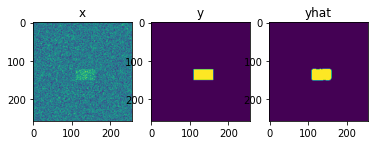

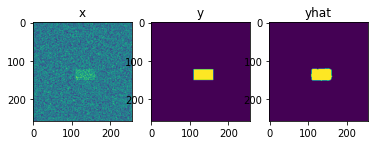

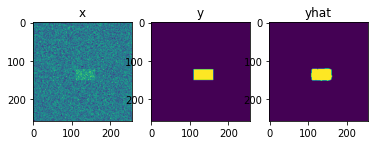

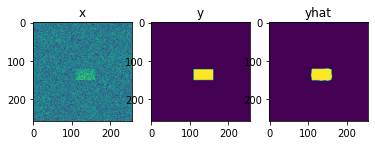

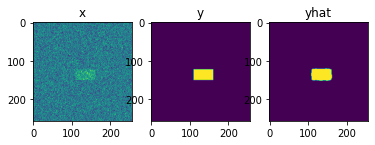

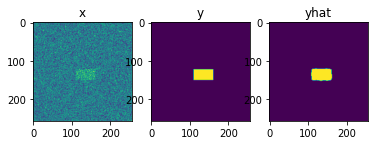

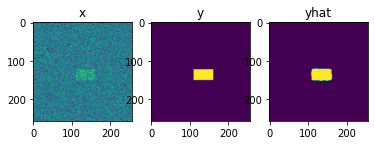

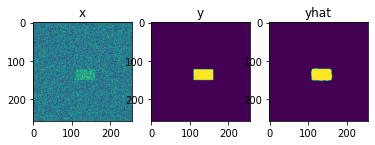

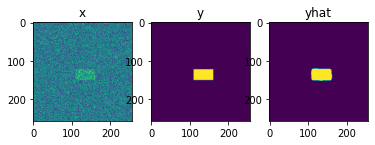

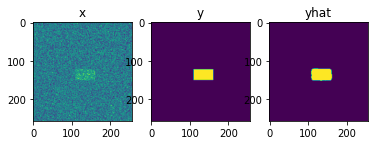

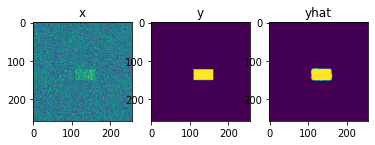

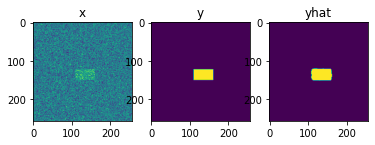

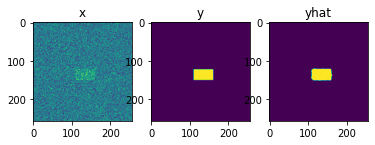

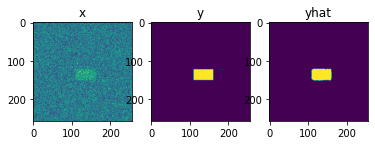

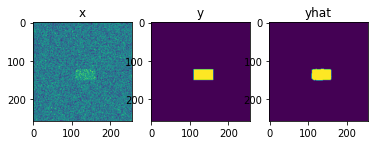

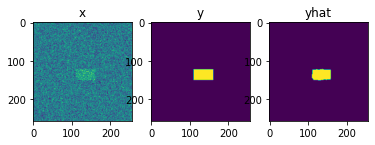

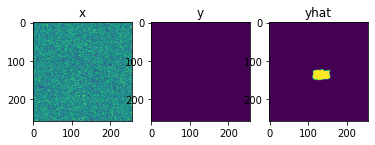

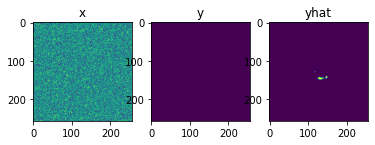

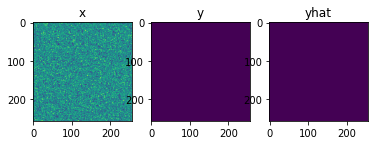

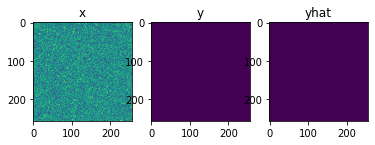

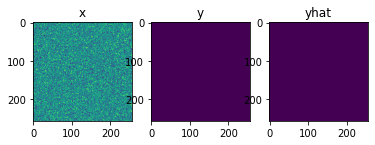

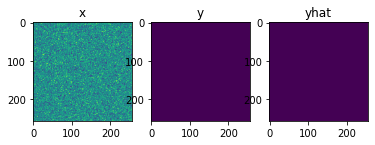

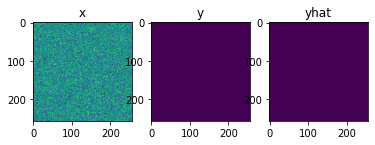

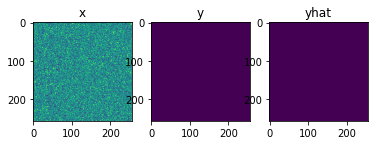

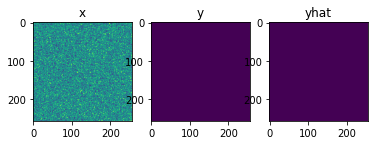

In [10]:
# test
net.eval()
with torch.no_grad():
  x,y = get_inputs3D()
  x,y = x.cuda(),y.cuda()
  yhat = net(x)
  yhat = activefn(yhat)
  print(x.shape,y.shape,yhat.shape,torch.unique(yhat))

  for idx_batch in range(x.shape[0]):
    print('\nidx_batch',idx_batch)
    for idx_depth in range(x.shape[-1]):
      plt.subplot(131)
      plt.title('x')
      plt.imshow(x[idx_batch,0,...,idx_depth].cpu().detach().numpy())    
      plt.subplot(132)
      plt.title('y')
      plt.imshow(y[idx_batch,0,...,idx_depth].cpu().detach().numpy())    
      plt.subplot(133)
      plt.title('yhat')
      plt.imshow(torch.argmax(yhat,1)[idx_batch,...,idx_depth].cpu().detach().numpy())
      plt.show()